In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER


In [2]:
import jax
import jax.numpy as jnp
from flax import nnx
from flax import struct
from functools import partial

import numpy as np

In [3]:
from ernestogym.envs_jax.single_agent.env import MicroGridEnv

In [4]:
def my_env_creator(params, battery_type, demand_profile):
    env = MicroGridEnv(params, battery_type, demand_profile)
    return env, env.params

In [5]:
# states = []

In [6]:
from ernestogym.envs_jax.single_agent.utils_new import parameter_generator

In [7]:
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
world = "ernestogym/envs_jax/single_agent/ijcnn_deg_train.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

params

{'battery': {'sign_convention': 'passive',
  'params': {'nominal_voltage': 350.4,
   'nominal_capacity': 60.0,
   'nominal_dod': 0.8,
   'nominal_lifetime': 3000,
   'v_max': 398.4,
   'v_min': 288.0,
   'temp_ambient': 298.15,
   'nominal_cost': 3000.0},
  'bounds': {'voltage': {'low': 288.0, 'high': 398.4},
   'current': {'low': -180.0, 'high': 60.0},
   'power': {'low': -71712.0, 'high': 23904.0},
   'temperature': {'low': 273.15, 'high': 323.15},
   'temp_ambient': {'low': 273.15, 'high': 323.15},
   'soc': {'low': 0.2, 'high': 1.0},
   'soh': {'low': 0.6, 'high': 1.0}},
  'init': {'voltage': 310.8,
   'current': 0.0,
   'power': 0.0,
   'temperature': 293.15,
   'temp_ambient': 293.15,
   'soc': 0.2,
   'soh': 1.0}},
 'input_var': 'current',
 'models_config': [{'type': 'electrical',
   'class_name': 'TheveninModel',
   'use_fading': False,
   'components': {'r0': {'selected_type': 'scalar',
     'scalar': 10.0,
     'lookup': {'table': 'r0_pack.csv',
      'inputs': [{'var': 'temp

In [8]:
a = jnp.array([[[[[[[2]]]]]]])
a = jnp.clip(a, 0, 1)
a.flatten()[0]
b = jnp.array(3)
b.flatten()

Array([3], dtype=int32, weak_type=True)

In [9]:
from algorithms.ppo import make_train, train
from flax.core.frozen_dict import freeze

2025-02-19 18:34:41.273171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739986481.285105  341588 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739986481.288748  341588 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
config = {
    "LR": 3e-4,
    "NUM_ENVS": 1,
    "NUM_STEPS": 2048, #10000,
    "TOTAL_TIMESTEPS": 250000,
    "UPDATE_EPOCHS": 10,
    "NUM_MINIBATCHES": 32,
    "NORMALIZE_ENV": False,
    "GAMMA": 0.9,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": None,
    "ANNEAL_LR": False,
    'DEBUG': False,
    "NORMALIZE_ADVANTAGES": True,
}

rng = jax.random.PRNGKey(42)

env, env_params = my_env_creator(params, battery_type, demand_profile='65')
env, env_params, train_state = make_train(config, env, env_params)
# out = train_jit(rng)

config = freeze(config)

In [11]:
network, optimizer = nnx.merge(train_state.graph_def, train_state.state)

In [12]:
network

ActorCritic(
  act_dense1=Linear(
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x7d046bfd09a0>,
    dot_general=<function dot_general at 0x7d057c15ad40>,
    dtype=None,
    in_features=10,
    kernel=Param(
      value=Array(shape=(10, 64), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x7d046bfd11c0>,
    out_features=64,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  ),
  act_dense2=Linear(
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x7d046be1f060>,
    dot_general=<function dot_general at 0x7d057c15ad40>,
    dtype=None,
    in_features=64,
    kernel=Param(
      value=Array(shape=(64, 64), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x7d046be1f380>,
    out_features=64,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,


time: 38.09 s


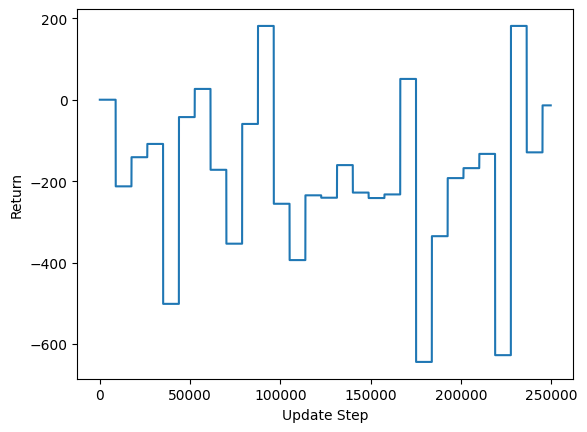

In [13]:
import time
import matplotlib.pyplot as plt
rng = jax.random.PRNGKey(42)
t0 = time.time()
out = jax.block_until_ready(train(env, env_params, config, train_state, rng))

train_state = out['runner_state'][0]

print(f"time: {time.time() - t0:.2f} s")
plt.plot(out["metrics"]["returned_episode_returns"].mean(-1).reshape(-1))
plt.xlabel("Update Step")
plt.ylabel("Return")
plt.show()

In [14]:
network, optimizer = nnx.merge(train_state.graph_def, train_state.state)
network

ActorCritic(
  act_dense1=Linear(
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x7d046bfd09a0>,
    dot_general=<function dot_general at 0x7d057c15ad40>,
    dtype=None,
    in_features=10,
    kernel=Param(
      value=Array(shape=(10, 64), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x7d046bfd11c0>,
    out_features=64,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  ),
  act_dense2=Linear(
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x7d046be1f060>,
    dot_general=<function dot_general at 0x7d057c15ad40>,
    dtype=None,
    in_features=64,
    kernel=Param(
      value=Array(shape=(64, 64), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x7d046be1f380>,
    out_features=64,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,


In [15]:
out

{'metrics': {'action': Array([[[[ 1.1671134 ]],
  
          [[-1.2348901 ]],
  
          [[-0.1942257 ]],
  
          ...,
  
          [[ 0.0103564 ]],
  
          [[ 0.2670767 ]],
  
          [[-0.45844367]]],
  
  
         [[[-0.20176119]],
  
          [[ 0.44662678]],
  
          [[-0.24534187]],
  
          ...,
  
          [[-0.98333114]],
  
          [[ 0.41810358]],
  
          [[ 0.66997164]]],
  
  
         [[[-0.00212836]],
  
          [[ 0.88880974]],
  
          [[-1.919703  ]],
  
          ...,
  
          [[ 0.4002806 ]],
  
          [[-1.900137  ]],
  
          [[ 0.5424093 ]]],
  
  
         ...,
  
  
         [[[-1.1852219 ]],
  
          [[-0.4613588 ]],
  
          [[ 0.48422134]],
  
          ...,
  
          [[-0.7146388 ]],
  
          [[-1.1057296 ]],
  
          [[-0.01712424]]],
  
  
         [[[-0.55803394]],
  
          [[-0.52840376]],
  
          [[-0.5313883 ]],
  
          ...,
  
          [[-1.5874738 ]],
  
          [[-

In [16]:
r_trad = out['metrics']['weig_reward']['r_trad'].mean(-1).reshape(-1)
r_trad_cum = np.cumsum(r_trad)
r_trad.shape

(249856,)

In [17]:
acts = out['metrics']['action'].flatten()
acts.min(), acts.max(), acts.mean()

(Array(-4.343107, dtype=float32),
 Array(4.1218615, dtype=float32),
 Array(-0.6183629, dtype=float32))

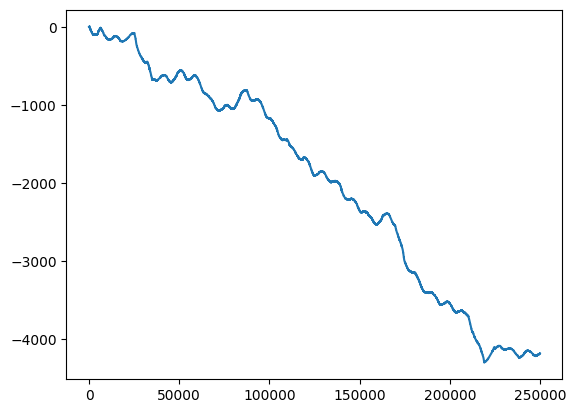

In [18]:
plt.plot(r_trad_cum)

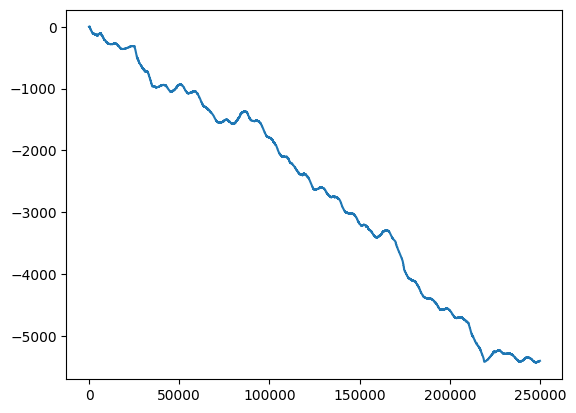

In [19]:
r_tot_cum = np.cumsum(out['metrics']['r_tot'].mean(-1).reshape(-1))
plt.plot(r_tot_cum)

# Testing

In [20]:
from ernestogym.envs_jax.single_agent.env import MicroGridEnv

In [21]:
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
world = "ernestogym/envs_jax/single_agent/ijcnn_deg_test.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

params['step']

3600

In [22]:
@partial(jax.jit, static_argnums=(0, 3))
def test(env: MicroGridEnv, env_params, train_state, num_iter, rng):
    network, _ = nnx.merge(train_state.graph_def, train_state.state)

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, env_params)

    def _env_step(runner_state, unused):
        obsv, env_state, rng = runner_state

        pi, _ = network(obsv)

        #deterministic action
        action = pi.mode()

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = env.step(_rng, env_state, action, env_params)

        runner_state = (obsv, env_state, rng)
        return runner_state, (info, action)

    runner_state = (obsv, env_state, rng)

    runner_state, info = jax.lax.scan(_env_step, runner_state, None, num_iter)

    return info

In [23]:
env, env_params = my_env_creator(params, battery_type, '65')
env_params = env.eval(env_params)

In [24]:
num_iter = 50000
info, actions = test(env, env_params, train_state, num_iter, jax.random.PRNGKey(51))


In [25]:
jax.tree.map(lambda val: val.shape, info)

{'i_to_apply': (50000,),
 'norm_reward': {'r_clipping': (50000,),
  'r_deg': (50000,),
  'r_op': (50000,),
  'r_trad': (50000,)},
 'pure_reward': {'r_clipping': (50000,),
  'r_deg': (50000,),
  'r_op': (50000,),
  'r_trad': (50000,)},
 'r_tot': (50000,),
 'soc': (50000,),
 'soh': (50000,),
 'weig_reward': {'r_clipping': (50000,),
  'r_deg': (50000,),
  'r_op': (50000,),
  'r_trad': (50000,)}}

In [26]:
actions.max(), actions.min(), actions.mean()

(Array(0.2178596, dtype=float32),
 Array(-1.2302177, dtype=float32),
 Array(-0.64916277, dtype=float32))

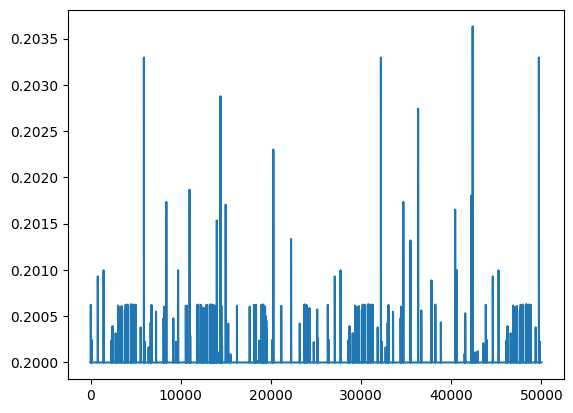

In [27]:
plt.plot(info['soc'])

In [28]:
reward_type = 'weig_reward'

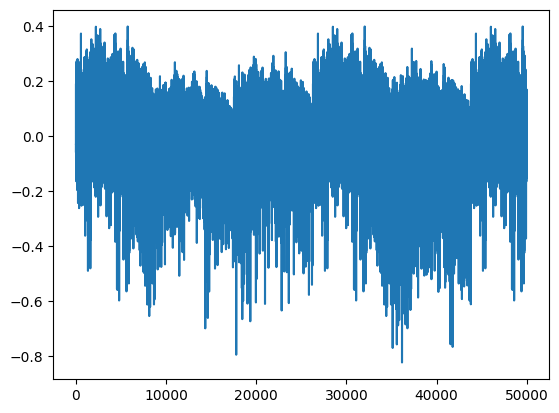

In [29]:
plt.plot(info[reward_type]['r_trad'])

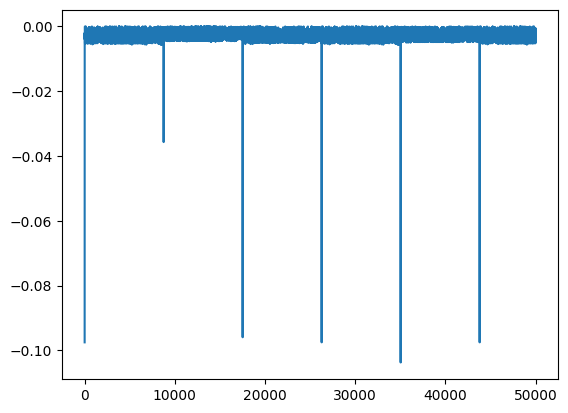

In [30]:
plt.plot(info[reward_type]['r_clipping'])

In [31]:
info['pure_reward']['r_clipping'].mean(), info['weig_reward']['r_clipping'].mean()

(Array(-6.514113, dtype=float32), Array(-0.0028576, dtype=float32))

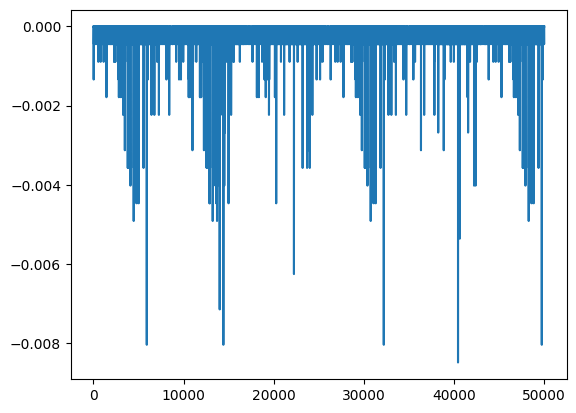

In [32]:
plt.plot(info[reward_type]['r_deg'])

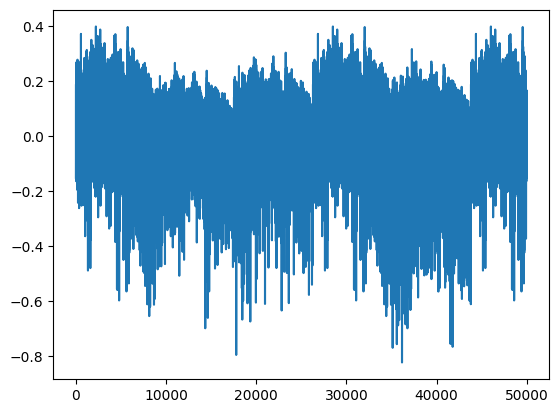

In [33]:
plt.plot(info['r_tot'])

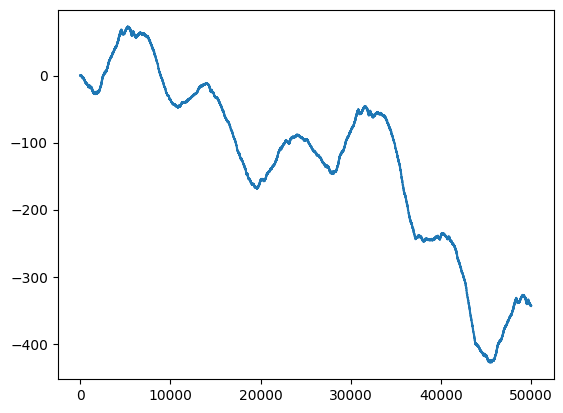

In [34]:
plt.plot(np.cumsum(info[reward_type]['r_trad']))

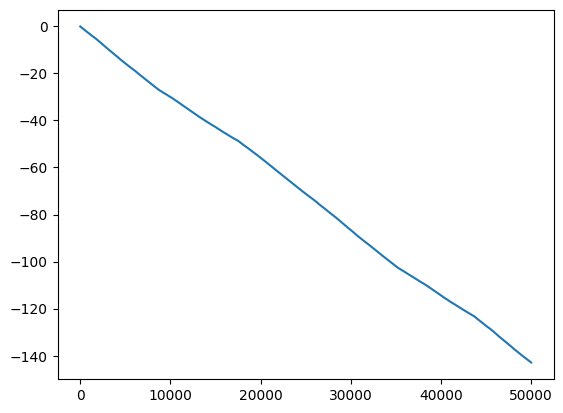

In [35]:
plt.plot(np.cumsum(info[reward_type]['r_clipping']))

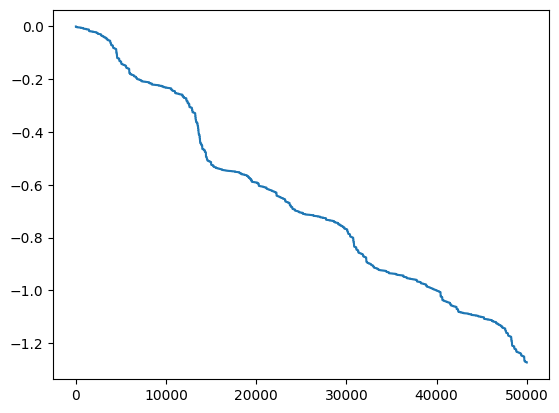

In [36]:
plt.plot(np.cumsum(info[reward_type]['r_deg']))

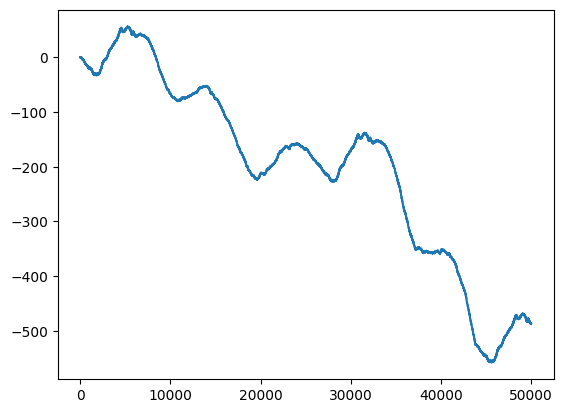

In [37]:
plt.plot(np.cumsum(info['r_tot']))

In [38]:
print(info['soc'])

[0.2 0.2 0.2 ... 0.2 0.2 0.2]


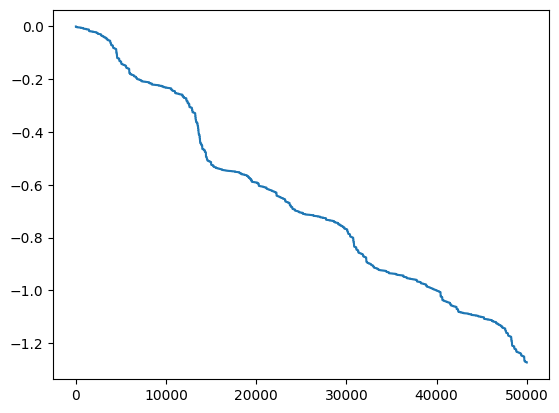

In [39]:
plt.plot(np.cumsum(info[reward_type]['r_deg']))

In [40]:
print(info['soc'])

[0.2 0.2 0.2 ... 0.2 0.2 0.2]
